<a href="https://colab.research.google.com/github/Cloblak/aipi540_deeplearning/blob/main/1D_CNN_Attempts/CDT1D_CNN_zach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install alpaca_trade_api

     |████████████████████████████████| 45 kB 1.0 MB/s 
     |████████████████████████████████| 53 kB 684 kB/s 
     |████████████████████████████████| 636 kB 26.8 MB/s 
     |████████████████████████████████| 1.3 MB 43.4 MB/s 
     |████████████████████████████████| 273 kB 46.7 MB/s 
     |████████████████████████████████| 103 kB 26.3 MB/s 
     |████████████████████████████████| 94 kB 754 kB/s 
     |████████████████████████████████| 271 kB 33.4 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.0.3
    Uninstalling msgpack-1.0.3:
      Successfully uninstalled msgpack-1.0.3


Features To Consider
 - Targets are only predicting sell within market hours, i.e. at 1530, target is prediciting price for 1100 the next day.  Data from pre and post market is taken into consideration, and a sell or buy will be indicated if the price will flucuate after close.

In [ ]:
# Import Dependencies
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import alpaca_trade_api as tradeapi
from datetime import datetime, timedelta, tzinfo, timezone, time
import os.path
import ast
import threading
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings

In [ ]:
random_seed = 182
torch.manual_seed(random_seed)

In [ ]:
PAPER_API_KEY = "PKE39LILN9SL1FMJMFV7"
PAPER_SECRET_KEY = "TkU7fXH6WhP15MewgWlSnQG5RUoHGOPQ7yqlD6xq"
PAPER_BASE_URL = 'https://paper-api.alpaca.markets'

In [ ]:
api = tradeapi.REST(PAPER_API_KEY, PAPER_SECRET_KEY, PAPER_BASE_URL, api_version='v2')

In [ ]:
def prepost_train_test_validate_offset_data(api, ticker, interval, train_days=180, test_days=60, validate_days=30, offset_days = 0):
    ticker_data_dict = None
    ticker_data_dict = {}
    monthly_data_dict = None
    monthly_data_dict = {}
    interval_loop_data = None
    interval_loop_data = pd.DataFrame()
    stock_data = None
    
    days_to_collect = train_days + test_days + validate_days + offset_days

    TZ = 'US/Eastern'

    start = pd.to_datetime((datetime.now() - timedelta(days=days_to_collect)).strftime("%Y-%m-%d %H:%M"), utc=True)
    end = pd.to_datetime(datetime.now().strftime("%Y-%m-%d %H:%M"), utc=True)

    stock_data = api.get_bars(ticker, interval, start = start.isoformat(), end=end.isoformat(), adjustment="raw").df
    
    interval_loop_data = interval_loop_data.append(stock_data)
    df_start_ref = interval_loop_data.index[0]
    start_str_ref = pd.to_datetime(start, utc=True)

    while start_str_ref.value < ( pd.to_datetime(df_start_ref, utc=True) - pd.Timedelta(days=2.5)).value:
        end_new = pd.to_datetime(interval_loop_data.index[0].strftime("%Y-%m-%d %H:%M"), utc=True).isoformat()
        stock_data_new = None
        stock_data_new = api.get_bars(ticker, interval, start=start, end=end_new, adjustment="raw").df
        #stock_data_new = stock_data_new.reset_index()
        interval_loop_data = interval_loop_data.append(stock_data_new).sort_values(by=['index'], ascending=True)
        df_start_ref = interval_loop_data.index[0]
        
    stock_yr_min_df = interval_loop_data.copy()
    stock_yr_min_df["Open"] = stock_yr_min_df['open']
    stock_yr_min_df["High"]= stock_yr_min_df["high"]
    stock_yr_min_df["Low"] = stock_yr_min_df["low"]
    stock_yr_min_df["Close"] = stock_yr_min_df["close"]
    stock_yr_min_df["Volume"] = stock_yr_min_df["volume"]
    stock_yr_min_df["VolumeWeightedAvgPrice"] = stock_yr_min_df["vwap"]
    stock_yr_min_df["Time"] = stock_yr_min_df.index.tz_convert(TZ)
    stock_yr_min_df.index = stock_yr_min_df.index.tz_convert(TZ)
    final_df = stock_yr_min_df.filter(["Time", "Open", "High", "Low", "Close", "Volume", "VolumeWeightedAvgPrice"], axis = 1)
    
    first_day = final_df.index[0]
    traintest_day = final_df.index[-1] - pd.Timedelta(days= test_days+validate_days+offset_days)
    valtest_day = final_df.index[-1] - pd.Timedelta(days= test_days+offset_days)
    last_day = final_df.index[-1] - pd.Timedelta(days= offset_days)
    training_df =  final_df.loc[first_day:traintest_day] #(data_split - pd.Timedelta(days=1))]
    validate_df = final_df.loc[traintest_day:valtest_day]
    testing_df =  final_df.loc[valtest_day:last_day]
    full_train = final_df.loc[first_day:last_day]
    offset_df =  final_df.loc[last_day:]

    return training_df, validate_df, testing_df, full_train, offset_df, final_df, traintest_day, valtest_day

from datetime import date

train_start = date(2017, 2, 18)
train_end = date(2020, 3, 29)
train_delta = train_end - train_start
print(f'Number of days of Training Data {train_delta.days}')

val_day_num = 400
print(f'Number of days of Validation Data {val_day_num}')

test_start = train_end + timedelta(val_day_num)
test_end = date.today()
test_delta = (test_end - test_start)
print(f'Number of days of Holdout Test Data {test_delta.days}')

ticker = "WEAT" # Ticker Symbol to Test
interval = "5Min" # Interval of bars
train_day_int = train_delta.days # Size of training set (Jan 2010 - Oct 2017)
val_day_int = val_day_num # Size of validation set
test_day_int = test_delta.days # Size of test set
offset_day_int = 60 # Number of days to off set the training data
train_raw, val_raw, test_raw, full_raw, offset_raw, complete_raw, traintest_day, testval_day = prepost_train_test_validate_offset_data(api, ticker, 
                                                                                     interval, 
                                                                                     train_days=train_day_int, 
                                                                                     test_days=test_day_int, 
                                                                                     validate_days=val_day_int,
                                                                                     offset_days = offset_day_int)

def timeFilterAndBackfill(df):
  """ 
  Prep df to be filled out for each trading day:
    Time Frame: 0930-1930
    Backfilling NaNs
    Adjusting Volume to Zero if no Trading data is present
      - Assumption is that there were no trades duing that time 

  We will build over lapping arrays by 30 min to give ourselfs more
  oppurtunities to predict during a given trading day 
  """
  
  df = df.between_time('07:29','17:29') # intial sorting of data

  TZ = 'US/Eastern' # define the correct timezone

  start_dateTime = pd.Timestamp(year = df.index[0].year, 
                                month = df.index[0].month, 
                                day = df.index[0].day, 
                                hour = 7, minute = 25, tz = TZ)

  end_dateTime = pd.Timestamp(year = df.index[-1].year, 
                              month = df.index[-1].month, 
                              day = df.index[-1].day, 
                              hour = 17, minute = 35, tz = TZ)

  # build blank index that has ever 5 min interval represented
  dateTime_index = pd.date_range(start_dateTime,
                                end_dateTime, 
                                freq='5min').tolist()

  dateTime_index_df = pd.DataFrame()
  dateTime_index_df["Time"] = dateTime_index 
  filtered_df = pd.merge_asof(dateTime_index_df, df,  
                              on='Time').set_index("Time").between_time('09:29','17:29')

  # create the close array by back filling NA, to represent no change in close
  closeset_list = []
  prev_c = None

  for c in filtered_df["Close"]:

    if prev_c == None:
      if math.isnan(c):
        prev_c = 0
        closeset_list.append(0)
      else:
        prev_c = c
        closeset_list.append(c)
    
    elif prev_c != None:
      if c == prev_c:
        closeset_list.append(c)
      elif math.isnan(c):
        closeset_list.append(prev_c)
      else:
        closeset_list.append(c)
        prev_c = c
    
  filtered_df["Close"] = closeset_list

  # create the volume
  volumeset_list = []
  prev_v = None

  for v in filtered_df["Volume"]:
    
    if prev_v == None:
      if math.isnan(v):
        prev_v = 0
        volumeset_list.append(0)
      else:
        prev_v = v
        volumeset_list.append(v)

    elif prev_v != None:
      if v == prev_v:
        volumeset_list.append(0)
        prev_v = v
      elif math.isnan(v):
        volumeset_list.append(0)
        prev_v = 0
      else:
        volumeset_list.append(v)
        prev_v = v

  filtered_df["Volume"] = volumeset_list
  
  adjvolumeset_list = []
  prev_v = None

  for v in filtered_df["VolumeWeightedAvgPrice"]:
    if prev_v == None:
      if math.isnan(v):
        prev_v = 0
        adjvolumeset_list.append(0)
      else:
        prev_v = v
        adjvolumeset_list.append(v)
    elif prev_v != None:
      if v == prev_v:
        adjvolumeset_list.append(0)
        prev_v = v
      elif math.isnan(v):
        adjvolumeset_list.append(0)
        prev_v = 0
      else:
        adjvolumeset_list.append(v)
        prev_v = v

  filtered_df["VolumeWeightedAvgPrice"] = adjvolumeset_list

  preped_df = filtered_df.backfill()

  return preped_df  

Number of days of Training Data 1135
Number of days of Validation Data 400
Number of days of Holdout Test Data 292


In [ ]:
train_raw[0:300]

,Time,Open,High,Low,Close,Volume,VolumeWeightedAvgPrice
timestamp,,,,,,,
2016-12-20 09:30:00-05:00,2016-12-20 09:30:00-05:00,6.8300,6.8300,6.7900,6.8000,6405,6.813110
2016-12-20 09:35:00-05:00,2016-12-20 09:35:00-05:00,6.8012,6.8012,6.8012,6.8012,585,6.801200
2016-12-20 09:40:00-05:00,2016-12-20 09:40:00-05:00,6.8100,6.8293,6.8100,6.8293,300,6.822867
2016-12-20 09:45:00-05:00,2016-12-20 09:45:00-05:00,6.8279,6.8279,6.8279,6.8279,100,6.827900
2016-12-20 09:55:00-05:00,2016-12-20 09:55:00-05:00,6.8842,6.9000,6.8842,6.8861,2140,6.892169
...,...,...,...,...,...,...,...
2016-12-29 13:25:00-05:00,2016-12-29 13:25:00-05:00,6.8500,6.8572,6.8500,6.8500,800,6.851788
2016-12-29 13:30:00-05:00,2016-12-29 13:30:00-05:00,6.8690,6.8690,6.8690,6.8690,200,6.869000
2016-12-29 13:35:00-05:00,2016-12-29 13:35:00-05:00,6.8500,6.8500,6.8421,6.8421,1350,6.842937


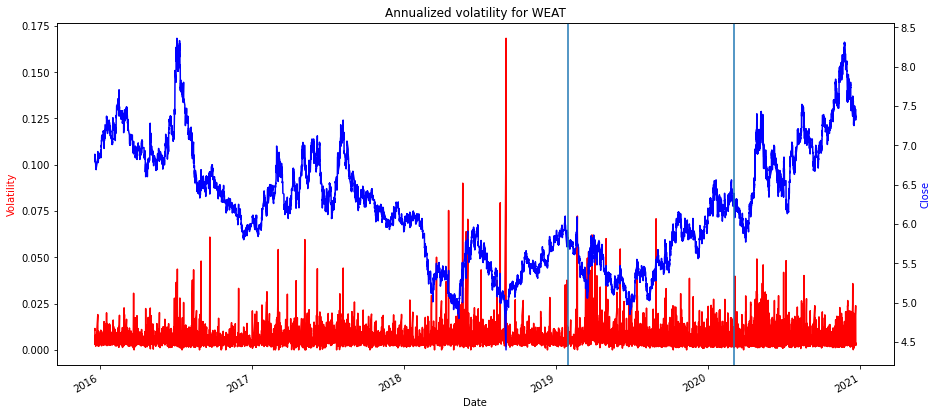

In [ ]:
def buildTargets_VolOnly(full_df = full_raw, train_observations = train_raw.shape[0], 
                         val_observations = val_raw.shape[0], 
                         test_observations = test_raw.shape[0], 
                         alph = .55, volity_int = 10):

  """ 
  This function will take a complete set of train, val, and test data and return the targets.
  Volitility will be calculated over the 252 5min incriments 
  The Target shift is looking at 2 hours shift from current time
  """

  returns = np.log(full_df['Close']/(full_df['Close'].shift()))
  returns.fillna(0, inplace=True)
  volatility = returns.rolling(window=(volity_int)).std()*np.sqrt(volity_int)



  return volatility
  #return train_targets, val_targets, test_targets, full_targets

volatility = buildTargets_VolOnly()

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 1, 1)
volatility.plot(ax=ax1, color = "red")
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility', color = "red")
ax1.set_title(f'Annualized volatility for {ticker}')
ax2 = ax1.twinx()
full_raw.Close.plot(ax=ax2, color = "blue")
ax2.set_ylabel('Close', color = "blue")
ax2.axvline(x=full_raw.index[train_raw.shape[0]])
ax2.axvline(x=full_raw.index[val_raw.shape[0]+train_raw.shape[0]])
plt.show()

In [ ]:
train = timeFilterAndBackfill(train_raw)
val = timeFilterAndBackfill(val_raw)
test = timeFilterAndBackfill(test_raw)

train = train[train.index.dayofweek <= 4].copy()
val = val[val.index.dayofweek <= 4].copy()
test = test[test.index.dayofweek <= 4].copy()

train["Open"] = np.where((train["Volume"] == 0), train["Close"], train["Open"])
train["High"] = np.where((train["Volume"] == 0), train["Close"], train["High"])
train["Low"] = np.where((train["Volume"] == 0), train["Close"], train["Low"])

val["Open"] = np.where((val["Volume"] == 0), val["Close"], val["Open"])
val["High"] = np.where((val["Volume"] == 0), val["Close"], val["High"])
val["Low"] = np.where((val["Volume"] == 0), val["Close"], val["Low"])

test["Open"] = np.where((test["Volume"] == 0), test["Close"], test["Open"])
test["High"] = np.where((test["Volume"] == 0), test["Close"], test["High"])
test["Low"] = np.where((test["Volume"] == 0), test["Close"], test["Low"])

def strided_axis0(a, L, overlap=1):
    if L==overlap:
        raise Exception("Overlap arg must be smaller than length of windows")
    S = L - overlap
    nd0 = ((len(a)-L)//S)+1
    if nd0*S-S!=len(a)-L:
        warnings.warn("Not all elements were covered")
    m,n = a.shape
    s0,s1 = a.strides
    return np.lib.stride_tricks.as_strided(a, shape=(nd0,L,n), strides=(S*s0,s0,s1))

# OLDER CODE WITHOUT OVERLAP OF LABELING
# def blockshaped(arr, nrows, ncols):
#     """
#     Return an array of shape (n, nrows, ncols) where
#     n * nrows * ncols = arr.size

#     If arr is a 2D array, the returned array should look like n subblocks with
#     each subblock preserving the "physical" layout of arr.
#     """
#     h, w = arr.shape
#     assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
#     assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
#     return np.flip(np.rot90((arr.reshape(h//nrows, nrows, -1, ncols)
#                .swapaxes(1,2)
#                .reshape(-1, nrows, ncols)), axes = (1, 2)), axis = 1)


def blockshaped(arr, nrows, ncols, overlapping_5min_intervals = 12):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """

    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"

    return np.flip(np.rot90((strided_axis0(arr, 24, overlap=overlapping_5min_intervals).reshape(-1, nrows, ncols)), axes = (1, 2)), axis = 1)

train_tonp = train[["Open", "High", "Low", "Close", "Volume"]]
val_tonp = val[["Open", "High", "Low", "Close", "Volume"]]
test_tonp = test[["Open", "High", "Low", "Close", "Volume"]]
train_array = train_tonp.to_numpy()
val_array = val_tonp.to_numpy()
test_array = test_tonp.to_numpy()

X_train_pre_final = blockshaped(train_array, 24, 5, overlapping_5min_intervals = 12)
X_val_pre_final = blockshaped(val_array, 24, 5, overlapping_5min_intervals = 12)
X_test_pre_final = blockshaped(test_array, 24, 5, overlapping_5min_intervals = 12)

# X_train_pre_final = blockshaped(train_array, 24, 5)
# X_val_pre_final = blockshaped(val_array, 24, 5)
# X_test_pre_final = blockshaped(test_array, 24, 5)

In [ ]:
np.set_printoptions(edgeitems=10,linewidth=580)
X_train_pre_final[0]

array([[   6.83  ,    6.8012,    6.81  ,    6.8279,    6.8279,    6.8842,    6.8965,    6.86  ,    6.8784,    6.8701,    6.8626,    6.8626,    6.85  ,    6.84  ,    6.8301,    6.8301,    6.8301,    6.8301,    6.84  ,    6.84  ,    6.84  ,    6.8434,    6.8434,    6.8434],
       [   6.83  ,    6.8012,    6.8293,    6.8279,    6.8279,    6.9   ,    6.8965,    6.86  ,    6.8784,    6.8798,    6.8626,    6.8626,    6.85  ,    6.84  ,    6.8301,    6.8301,    6.8301,    6.8301,    6.84  ,    6.84  ,    6.84  ,    6.8434,    6.8434,    6.8434],
       [   6.79  ,    6.8012,    6.81  ,    6.8279,    6.8279,    6.8842,    6.8701,    6.86  ,    6.8784,    6.87  ,    6.8626,    6.8626,    6.85  ,    6.83  ,    6.8301,    6.8301,    6.8301,    6.8301,    6.84  ,    6.84  ,    6.84  ,    6.8434,    6.8434,    6.8434],
       [   6.8   ,    6.8012,    6.8293,    6.8279,    6.8279,    6.8861,    6.8701,    6.86  ,    6.8784,    6.8798,    6.8626,    6.8626,    6.85  ,    6.8301,    6.8301,    6.830

In [ ]:
train_tonp[0:24]

,Open,High,Low,Close,Volume
Time,,,,,
2016-12-20 09:30:00-05:00,6.8300,6.8300,6.7900,6.8000,6405.0
2016-12-20 09:35:00-05:00,6.8012,6.8012,6.8012,6.8012,585.0
2016-12-20 09:40:00-05:00,6.8100,6.8293,6.8100,6.8293,300.0
2016-12-20 09:45:00-05:00,6.8279,6.8279,6.8279,6.8279,100.0
2016-12-20 09:50:00-05:00,6.8279,6.8279,6.8279,6.8279,0.0
2016-12-20 09:55:00-05:00,6.8842,6.9000,6.8842,6.8861,2140.0
2016-12-20 10:00:00-05:00,6.8965,6.8965,6.8701,6.8701,3741.0
2016-12-20 10:05:00-05:00,6.8600,6.8600,6.8600,6.8600,1000.0
2016-12-20 10:10:00-05:00,6.8784,6.8784,6.8784,6.8784,0.0


In [ ]:
X_train_pre_final[1]

array([[   6.85  ,    6.84  ,    6.8301,    6.8301,    6.8301,    6.8301,    6.84  ,    6.84  ,    6.84  ,    6.8434,    6.8434,    6.8434,    6.8434,    6.8237,    6.83  ,    6.83  ,    6.8443,    6.8499,    6.8499,    6.8499,    6.83  ,    6.8201,    6.82  ,    6.84  ],
       [   6.85  ,    6.84  ,    6.8301,    6.8301,    6.8301,    6.8301,    6.84  ,    6.84  ,    6.84  ,    6.8434,    6.8434,    6.8434,    6.8434,    6.8237,    6.83  ,    6.83  ,    6.8443,    6.8499,    6.8499,    6.8499,    6.83  ,    6.8201,    6.84  ,    6.84  ],
       [   6.85  ,    6.83  ,    6.8301,    6.8301,    6.8301,    6.8301,    6.84  ,    6.84  ,    6.84  ,    6.8434,    6.8434,    6.8434,    6.8434,    6.8237,    6.83  ,    6.83  ,    6.8443,    6.8499,    6.8499,    6.8499,    6.83  ,    6.8201,    6.82  ,    6.84  ],
       [   6.85  ,    6.8301,    6.8301,    6.8301,    6.8301,    6.8301,    6.84  ,    6.84  ,    6.84  ,    6.8434,    6.8434,    6.8434,    6.8434,    6.8237,    6.83  ,    6.83 

In [ ]:
# create target from OHLC and Volume Data
###### THIS IS FOR 3 CLASS FROM PAPER ########
# def buildTargets(obs_array,  
#                  alph = .55, 
#                  volity_int = 10):

#   """ 
#   This function will take a complete set of train, val, and test 
#   data and return the targets. Volitility will be calculated over 
#   the 24 5min incriments. The Target shift is looking at 2 hours 
#   shift from current time

#   shift_2hour = The amount of time the data interval take to equal 2 hours 
#                 (i.e. 5 min data interval is equal to 24)
#   alph = The alpha value for calculating the shift in price
#   volity_int = the number of incriments used to calculate volitility 
#   """

#   target_close_list =[]

#   for arr in obs_array:
#     target_close_list.append(arr[3][-1])
  
#   target_close_df = pd.DataFrame()
#   target_close_df["Close"] = target_close_list

#   target_close_df["Volitility"] = target_close_df["Close"].rolling(volity_int).std()

#   # print(len(volatility), len(target_close_df["Close"]))

  
#   targets = [0] * len(target_close_df.Close)

#   targets = np.where(target_close_df.Close.shift() >= (target_close_df.Close * (1 + alph * target_close_df["Volitility"])), 
#            2, targets)
  
#   targets = np.where(target_close_df.Close.shift() <= (target_close_df.Close * (1 - alph * target_close_df["Volitility"])), 
#            1, targets)

#   return targets


#####DISREGUARD THE VOLITLITY######
def buildTargets(obs_array,  
                 alph = .55, 
                 volity_int = 10):

  """ 
  This function will take a complete set of train, val, and test 
  data and return the targets. Volitility will be calculated over 
  the 24 5min incriments. The Target shift is looking at 2 hours 
  shift from current time

  shift_2hour = The amount of time the data interval take to equal 2 hours 
                (i.e. 5 min data interval is equal to 24)
  alph = The alpha value for calculating the shift in price
  volity_int = the number of incriments used to calculate volitility 
  """

  target_close_list =[]

  for arr in obs_array:
    target_close_list.append(arr[3][-1])
  
  target_close_df = pd.DataFrame()
  target_close_df["Close"] = target_close_list

  target_close_df["Volitility"] = target_close_df["Close"].rolling(volity_int).std()
  
  targets = [0] * len(target_close_df.Close)

  targets = np.where(target_close_df.Close.shift() >= (target_close_df.Close * (1 + alph)), 
           2, targets)
  
  targets = np.where(target_close_df.Close.shift() <= (target_close_df.Close * (1 - alph)), 
           1, targets)

  return targets

  #####Binary Class######
# def buildTargets(obs_array,  
#                  alph = .55, 
#                  volity_int = 10):

#   """ 
#   This function will take a complete set of train, val, and test 
#   data and return the targets. Volitility will be calculated over 
#   the 24 5min incriments. The Target shift is looking at 2 hours 
#   shift from current time

#   shift_2hour = The amount of time the data interval take to equal 2 hours 
#                 (i.e. 5 min data interval is equal to 24)
#   alph = The alpha value for calculating the shift in price
#   volity_int = the number of incriments used to calculate volitility 
#   """

#   target_close_list =[]

#   for arr in obs_array:
#     target_close_list.append(arr[3][-1])
  
#   target_close_df = pd.DataFrame()
#   target_close_df["Close"] = target_close_list

#   target_close_df["Volitility"] = target_close_df["Close"].rolling(volity_int).std()

#   # print(len(volatility), len(target_close_df["Close"]))

  
#   targets = [0] * len(target_close_df.Close)

#   targets = np.where(target_close_df.Close.shift() >= (target_close_df.Close * (1 + alph)), 
#            1, targets)

#   return targets

In [ ]:
volity_val = 10
alph = .0015
y_train_pre_final = buildTargets(X_train_pre_final, alph=alph,  volity_int = volity_val)
y_val_pre_final = buildTargets(X_val_pre_final, alph=alph, volity_int = volity_val)
y_test_pre_final = buildTargets(X_test_pre_final, alph=alph, volity_int = volity_val)

In [ ]:
def get_class_distribution(obj):
    count_dict = {
        "up": 0,
        "flat": 0,
        "down": 0,
    }
    
    for i in obj:
        if i == 2: 
            count_dict['up'] += 1
        elif i == 1: 
            count_dict['down'] += 1
        elif i == 0: 
            count_dict['flat'] += 1             
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

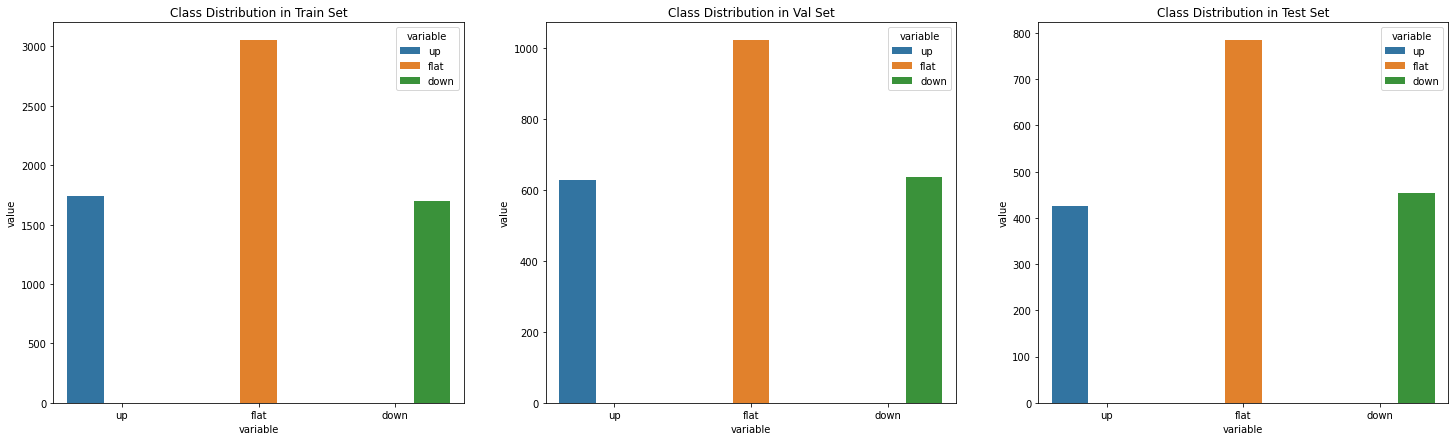

In [ ]:
bfig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train_pre_final)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val_pre_final)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test_pre_final)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [ ]:
def createFinalData_RemoveLateAfternoonData(arr, labels):

  assert arr.shape[0] == len(labels), "X data do not match length of y labels"

  step_count = 0
  filtered_y_labels = []

  for i in range(arr.shape[0]):

    if i == 0:
      final_arr = arr[i]
      filtered_y_labels.append(labels[i])
      #print(f'Appending index {i}, step_count: {step_count}')
      step_count += 1

    elif i == 1:

      final_arr = np.stack((final_arr, arr[i]))
      filtered_y_labels.append(labels[i])
      step_count += 1

    elif step_count == 0: 
      final_arr = np.vstack((final_arr, arr[i][None]))
      filtered_y_labels.append(labels[i])
      #print(f'Appending index {i}, step_count: {step_count}')
      step_count += 1
    
    elif (step_count) % 5 == 0:
      #print(f'skipping {i} array, step_count: {step_count}')
      step_count += 1

    elif (step_count) % 6 == 0:
      #print(f'skipping {i} array, step_count: {step_count}')
      step_count += 1

    elif (step_count) % 7 == 0:
      #print(f'skipping {i} array, step_count: {step_count}')
      step_count = 0
    
    else:
      final_arr = np.vstack((final_arr, arr[i][None]))
      filtered_y_labels.append(labels[i])
      #print(f'Appending index {i}, step_count: {step_count}')
      step_count += 1
  
  return final_arr, filtered_y_labels

X_train, y_train = createFinalData_RemoveLateAfternoonData(X_train_pre_final, y_train_pre_final)
X_val, y_val = createFinalData_RemoveLateAfternoonData(X_val_pre_final, y_val_pre_final)
X_test, y_test = createFinalData_RemoveLateAfternoonData(X_test_pre_final, y_test_pre_final)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [ ]:
# Check it arrays are made correctly
train[12:48]

,Open,High,Low,Close,Volume,VolumeWeightedAvgPrice
Time,,,,,,
2016-12-20 10:30:00-05:00,6.8500,6.8500,6.8500,6.8500,400.0,6.850000
2016-12-20 10:35:00-05:00,6.8400,6.8400,6.8300,6.8301,926.0,6.834331
2016-12-20 10:40:00-05:00,6.8301,6.8301,6.8301,6.8301,0.0,0.000000
2016-12-20 10:45:00-05:00,6.8301,6.8301,6.8301,6.8301,0.0,0.000000
2016-12-20 10:50:00-05:00,6.8301,6.8301,6.8301,6.8301,0.0,0.000000
2016-12-20 10:55:00-05:00,6.8301,6.8301,6.8301,6.8301,0.0,0.000000
2016-12-20 11:00:00-05:00,6.8400,6.8400,6.8400,6.8400,1174.0,6.840000
2016-12-20 11:05:00-05:00,6.8400,6.8400,6.8400,6.8400,300.0,0.000000
2016-12-20 11:10:00-05:00,6.8400,6.8400,6.8400,6.8400,0.0,0.000000


In [ ]:
np.set_printoptions(threshold=200)
y_train_pre_final[50:75]

array([1, 2, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
######
# Code fro scaling at a later date
######

# from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import StandardScaler

scalers = {}
for i in range(X_train.shape[1]):
    scalers[i] = StandardScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

for i in range(X_val.shape[1]):
    X_val[:, i, :] = scalers[i].transform(X_val[:, i, :]) 

for i in range(X_test.shape[1]):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 
    

In [ ]:
def get_class_distribution(obj):
    count_dict = {
        "up": 0,
        "flat": 0,
        "down": 0,
    }
    
    for i in obj:
        if i == 2: 
            count_dict['up'] += 1
        elif i == 1: 
            count_dict['down'] += 1
        elif i == 0: 
            count_dict['flat'] += 1             
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

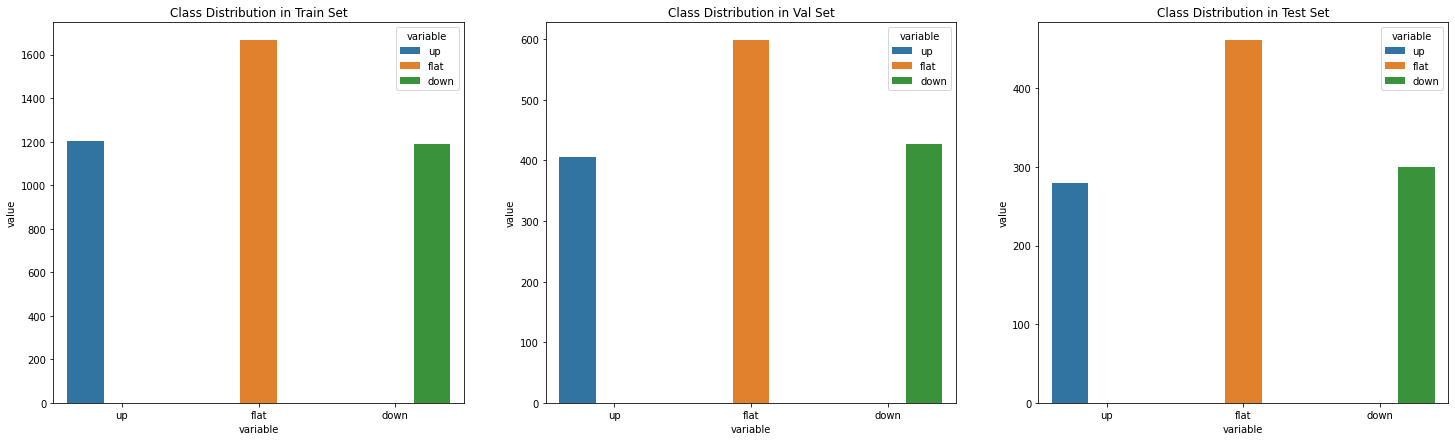

In [ ]:
bfig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

#Keras Model Conv2D

In [ ]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Flatten, Dense, Activation
from keras.utils import np_utils
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam, Nadam


In [ ]:
###### ONLY EXECUTE FOR KERAS 2D CNN #####

X_train_2d = X_train.reshape(X_train.shape[0], 
                          X_train.shape[1], 
                          X_train.shape[2],
                          1
                          )
X_val_2d = X_val.reshape(X_val.shape[0],
                          X_val.shape[1], 
                          X_val.shape[2],
                          1
                          )
X_test_2d = X_test.reshape(X_test.shape[0],
                          X_test.shape[1], 
                          X_test.shape[2],
                          1
                          )

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 3)
y_val = to_categorical(y_val, 3)
y_test = to_categorical(y_test, 3)

In [ ]:
print(f'X Train Length {X_train_2d.shape}, y Train Label Length {y_train.shape}')
print(f'X Val Length {X_val_2d.shape}, y Val Label Length {y_val.shape}')
print(f'X Test Length {X_test_2d.shape}, y Test Label Length {y_test.shape}')

X Train Length (4055, 5, 24, 1), y Train Label Length (4055, 3)
X Val Length (1430, 5, 24, 1), y Val Label Length (1430, 3)
X Test Length (1040, 5, 24, 1), y Test Label Length (1040, 3)


In [ ]:
# data_format='channels_first'
#Create model
model = Sequential()
model.add(Convolution2D(filters=32, kernel_size=(1, 4), padding='same', activation='relu', input_shape=(X_train_2d.shape[1],X_train_2d.shape[2],X_train_2d.shape[3])))
model.add(MaxPooling2D(pool_size=(1,4), strides=(1, 4), padding='same'))
model.add(Dropout(0.7))
model.add(Convolution2D(filters=64, kernel_size=(1,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(1,3), strides=(1, 3), padding='same'))
model.add(Dropout(0.7))
model.add(Convolution2D(filters=128, kernel_size=(1,2), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(1,2), strides=(1,2), padding='same'))
model.add(Dropout(0.7))
model.add(Flatten())
model.add(Dense(1000,activation="relu"))
model.add(Dense(500,activation="relu"))
model.add(Dense(3,activation="softmax"))
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 5, 24, 32)         160       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 5, 6, 32)         0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 5, 6, 32)          0         
                                                                 
 conv2d_21 (Conv2D)          (None, 5, 6, 64)          6208      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 5, 2, 64)         0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 5, 2, 64)        

In [ ]:
adam = Adam(learning_rate=0.001, decay=0.0001)
nadam = Nadam(learning_rate=0.002, schedule_decay=0.004)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=["accuracy"]) 

In [ ]:
batch_size = 12
hist = model.fit(X_train_2d, y_train, batch_size=batch_size, epochs=350, validation_data=(X_val_2d, y_val)) #, class_weight={0:1, 1:1.5})

Epoch 1/350
338/338 [==============================] - 9s 21ms/step - loss: 1.1181 - accuracy: 0.3988 - val_loss: 1.0789 - val_accuracy: 0.4210
Epoch 2/350
338/338 [==============================] - 7s 20ms/step - loss: 1.0796 - accuracy: 0.4197 - val_loss: 1.0738 - val_accuracy: 0.4189
Epoch 3/350
338/338 [==============================] - 7s 20ms/step - loss: 1.0775 - accuracy: 0.4229 - val_loss: 1.0732 - val_accuracy: 0.4182
Epoch 4/350
338/338 [==============================] - 7s 21ms/step - loss: 1.0739 - accuracy: 0.4266 - val_loss: 1.0721 - val_accuracy: 0.4189
Epoch 5/350
338/338 [==============================] - 8s 25ms/step - loss: 1.0715 - accuracy: 0.4252 - val_loss: 1.0666 - val_accuracy: 0.4175
Epoch 6/350
338/338 [==============================] - 7s 21ms/step - loss: 1.0744 - accuracy: 0.4192 - val_loss: 1.0659 - val_accuracy: 0.4203
Epoch 7/350
 39/338 [==>...........................] - ETA: 5s - loss: 1.0857 - accuracy: 0.4060

In [ ]:
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

In [ ]:
plt.plot(hist.history['accuracy'], label='train acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
y_pred = model.predict(X_test_2d)

In [ ]:
y_pred

In [ ]:
# Calculate the accuracy
test_preds = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
test_acc = np.sum(test_preds == y_true)/y_true.shape[0]

# Recall for each class
recall_vals = []
for i in range(3):
    class_idx = np.argwhere(y_true==i)
    total = len(class_idx)
    correct = np.sum(test_preds[class_idx]==i)
    recall = correct / total
    recall_vals.append(recall)

classes = [0,1,2]
# Calculate the test set accuracy and recall for each class
print('Test set accuracy is {:.3f}'.format(test_acc))
for i in range(3):
    print('For class {}, recall is {:.3f}'.format(classes[i],recall_vals[i]))

print("Accuracy is {:.3f}".format(test_acc))
# print("Weighted F score is {:.3f}".format(calculate_weighted_f_score(y_true, y_pred)))

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

nb_classes = 3

# Confusion matrix
conf_mat=confusion_matrix(y_true, np.argmax(y_pred, axis=-1))
plot_confusion_matrix(conf_mat, ["flat","down","up"])

from sklearn.metrics import precision_score

precision_score(y_true, np.argmax(y_pred, axis=-1), average='weighted')

from sklearn.metrics import classification_report

print(classification_report(y_true, np.argmax(y_pred, axis=-1), target_names=["flat","down", "up"], digits=4))

In [ ]:
def calculate_weighted_f_score(y_true, y_pred):
  test_preds = np.argmax(y_pred, axis=-1)
  Ntu = sum((test_preds == 2) & (y_true == 2))
  Ntd = sum((test_preds == 1) & (y_true == 1))
  Ntf = sum((test_preds == 0) & (y_true == 0))
  Ewutd = sum((test_preds == 2) & (y_true == 1))
  Ewdtu = sum((test_preds == 1) & (y_true == 2))
  Ewutf = sum((test_preds == 2) & (y_true == 0))
  Ewdtf = sum((test_preds == 1) & (y_true == 0))
  Ewftu = sum((test_preds == 0) & (y_true == 2))
  Ewftd = sum((test_preds == 0) & (y_true == 1))

  beta_1 = 0.5
  beta_2 = 0.125
  beta_3 = 0.125

  Ntp = Ntu + Ntd + beta_3**2 * Ntf
  E1 = Ewutd + Ewdtu
  E2 = Ewutf + Ewdtf
  E3 = Ewftu + Ewftd

  F = (1 + beta_1**2 + beta_2**2) * Ntp / ((1+beta_1**2+beta_2**2) * Ntp + E1 + beta_1**2 * E2 + beta_2**2 * E3)
  return  F

print(f'Weight CDT F Score: {calculate_weighted_f_score(y_true, y_pred)}')

# PyTorch Model Conv2D

In [ ]:
###### ONLY EXECUTE FOR PYTORCH 2D CNN #####

X_train = X_train.reshape(X_train.shape[0], 
                          1,
                          X_train.shape[1], 
                          X_train.shape[2]
                          )
X_val = X_val.reshape(X_val.shape[0],
                          1,
                          X_val.shape[1], 
                          X_val.shape[2],
                          )
X_test = X_test.reshape(X_test.shape[0],
                          1,
                          X_test.shape[1], 
                          X_test.shape[2],
                          )

In [ ]:
print(f'X Train Length {X_train.shape}, y Train Label Length {y_train.shape}')
print(f'X Val Length {X_val.shape}, y Val Label Length {y_val.shape}')
print(f'X Test Length {X_test.shape}, y Test Label Length {y_test.shape}')

X Train Length (4060, 1, 5, 24), y Train Label Length (4060,)
X Val Length (1435, 1, 5, 24), y Val Label Length (1435,)
X Test Length (1040, 1, 5, 24), y Test Label Length (1040,)


In [ ]:
trainset = TensorDataset(torch.from_numpy(X_train).float(), 
                         torch.from_numpy(y_train).long())
testset = TensorDataset(torch.from_numpy(X_test).float(), 
                        torch.from_numpy(y_test).long())

In [ ]:
train_loader = torch.utils.data.DataLoader(trainset, shuffle=False)
i1, l1 = next(iter(train_loader))
print(i1.shape)

# val_data = []
# for i in range(len(X_val)):
#    val_data.append([X_val[i].astype('float'), y_val[i]])

val_loader = torch.utils.data.DataLoader(testset, shuffle=False)
i1, l1 = next(iter(val_loader))
print(i1.shape)

torch.Size([1, 1, 5, 24])
torch.Size([1, 1, 5, 24])


In [ ]:
# Get next batch of training images
windows, labels = iter(train_loader).next()
print(windows.shape)
windows = windows.numpy()
batch_size = 12
# plot the windows in the batch, along with the corresponding labels
fig = plt.figure(figsize=(15, 5))
for idx in range(batch_size):
    print(labels)

torch.Size([1, 1, 5, 24])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])


<Figure size 1080x360 with 0 Axes>

In [ ]:
# Set up dict for dataloaders
dataloaders = {'train':train_loader,'val':val_loader}
# Store size of training and validation sets
dataset_sizes = {'train':len(train_loader),'val':len(val_loader)}
# Get class names associated with labels
classes = [0,1,2]

In [ ]:
class StockShiftClassification(nn.Module):
  def __init__(self):
    super(StockShiftClassification, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size = (1,3), stride=1, padding = 1)
    self.pool1 = nn.MaxPool2d((1,4),4)

    self.conv2 = nn.Conv2d(32, 64, kernel_size = (1,3), stride=1, padding = 1)
    self.pool2 = nn.MaxPool2d((1,3),3)  

    self.conv3 = nn.Conv2d(64, 128, kernel_size = (1,3), stride=1, padding = 1)
    self.pool3 = nn.MaxPool2d((1,2),2)

    self.fc1 = nn.Linear(256,1000) #calculate this
    self.fc2 = nn.Linear(1000,500)
    self.fc3 = nn.Linear(500,3)

    self.drop = nn.Dropout(p=0.7)

  def forward(self, x):

    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = self.drop(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = self.drop(x)
    x = F.relu(self.conv3(x))
    x = self.pool3(x)
    x = self.drop(x)

    x = x.view(x.size(0), -1)

    # Linear layer
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)

    output = x #F.log_softmax(x, dim=1)

    return output

In [ ]:
# Instantiate the model
net = StockShiftClassification().float()

# Display a summary of the layers of the model and output shape after each layer
summary(net,(windows.shape[1:]),batch_size=batch_size,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [12, 32, 7, 24]             128
         MaxPool2d-2             [12, 32, 2, 6]               0
           Dropout-3             [12, 32, 2, 6]               0
            Conv2d-4             [12, 64, 4, 6]           6,208
         MaxPool2d-5             [12, 64, 2, 2]               0
           Dropout-6             [12, 64, 2, 2]               0
            Conv2d-7            [12, 128, 4, 2]          24,704
         MaxPool2d-8            [12, 128, 2, 1]               0
           Dropout-9            [12, 128, 2, 1]               0
           Linear-10                 [12, 1000]         257,000
           Linear-11                  [12, 500]         500,500
           Linear-12                    [12, 3]           1,503
Total params: 790,043
Trainable params: 790,043
Non-trainable params: 0
-------------------------------

In [ ]:
train_x = torch.from_numpy(X_train).float()
train_y = torch.from_numpy(y_train).long()
val_x = torch.from_numpy(X_val).float()
val_y = torch.from_numpy(y_val).long()

In [ ]:
def train_model(model, criterion, optimizer, train_loaders, device, num_epochs=50, scheduler):

    model = model.to(device) # Send model to GPU if available

    writer = SummaryWriter() # Instantiate TensorBoard

    iter_num = {'train':0,'val':0} # Track total number of iterations

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Get the input images and labels, and send to GPU if available
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # print(outputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += loss.item() * inputs.size(0)
                # Track number of correct predictions
                running_corrects += torch.sum(preds == labels.data)

                # Iterate count of iterations
                iter_num[phase] += 1

                # Write loss for batch to TensorBoard
                writer.add_scalar("{} / batch loss".format(phase), loss.item(), iter_num[phase])

                # scheduler.step()

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Write loss and accuracy for epoch to TensorBoard
            writer.add_scalar("{} / epoch loss".format(phase), epoch_loss, epoch)
            writer.add_scalar("{} / epoch accuracy".format(phase), epoch_acc, epoch)

    writer.close()
    
    return

SyntaxError: ignored

In [ ]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cross entropy loss combines softmax and nn.NLLLoss() in one single class.
weights = torch.tensor([1.5, 2.25, 1.]).to(device)
criterion_weighted = nn.CrossEntropyLoss(weight=weights)

criterion = nn.CrossEntropyLoss()

# Define optimizer
#optimizer = optim.SGD(net.parameters(), lr=0.001)
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.00001)


n_epochs= 500 # For demo purposes.  Use epochs>100 for actual training

onecycle_scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                        max_lr=0.01,
                                        base_momentum = 0.8,
                                        steps_per_epoch=len(train_loader),
                                        epochs=n_epochs)


train_model(net, criterion, optimizer, dataloaders, device, num_epochs=n_epochs, scheduler=onecycle_scheduler)

TypeError: ignored

# KERAS 1D Model

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 3)
y_val = to_categorical(y_val, 3)
y_test = to_categorical(y_test, 3)


In [ ]:
print(f'X Train Length {X_train.shape}, y Train Label Length {y_train.shape}')
print(f'X Val Length {X_val.shape}, y Val Label Length {y_val.shape}')
print(f'X Test Length {X_test.shape}, y Test Label Length {y_test.shape}')

X Train Length (4060, 5, 24), y Train Label Length (4060, 3)
X Val Length (1435, 5, 24), y Val Label Length (1435, 3)
X Test Length (1040, 5, 24), y Test Label Length (1040, 3)


In [ ]:
import tensorflow as tf
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.optimizers import Adam, Nadam

In [ ]:
# Simple Model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(MaxPooling1D(pool_size=3, strides=4, padding='same'))
model.add(Dropout(0.7))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
model.add(Dropout(0.7))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))
model.add(Dropout(0.7))
model.add(Flatten())
model.add(Dense(1000,activation="relu"))
model.add(Dense(500,activation="relu"))
model.add(Dense(3,activation="softmax"))
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 5, 32)             2336      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 2, 32)            0         
 1D)                                                             
                                                                 
 dropout_37 (Dropout)        (None, 2, 32)             0         
                                                                 
 conv1d_4 (Conv1D)           (None, 2, 64)             6208      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 dropout_38 (Dropout)        (None, 1, 64)           

In [ ]:
adam = Adam(learning_rate=0.001, decay=0.0001)
nadam = Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)

def custom_loss_function(y_true, y_pred):
   squared_difference = tf.square(y_true - y_pred)
   return tf.reduce_mean(squared_difference, axis=-1)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=["accuracy"]) 

In [ ]:
batch_size = 12
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=350, validation_data=(X_val, y_val)) #, class_weight={0:1, 1:1.5})

Epoch 1/350
335/339 [============================>.] - ETA: 0s - loss: 0.9849 - accuracy: 0.5032

KeyboardInterrupt: ignored

In [ ]:
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

In [ ]:
plt.plot(hist.history['accuracy'], label='train acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
# Calculate the accuracy
test_preds = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
test_acc = np.sum(test_preds == y_true)/y_true.shape[0]

# Recall for each class
recall_vals = []
for i in range(3):
    class_idx = np.argwhere(y_true==i)
    total = len(class_idx)
    correct = np.sum(test_preds[class_idx]==i)
    recall = correct / total
    recall_vals.append(recall)

classes = [0,1,2]
# Calculate the test set accuracy and recall for each class
print('Test set accuracy is {:.3f}'.format(test_acc))
for i in range(3):
    print('For class {}, recall is {:.3f}'.format(classes[i],recall_vals[i]))

print("Accuracy is {:.3f}".format(test_acc))
# print("Weighted F score is {:.3f}".format(calculate_weighted_f_score(y_true, y_pred)))

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

nb_classes = 2

# Confusion matrix
conf_mat=confusion_matrix(y_true, np.argmax(y_pred, axis=-1))
plot_confusion_matrix(conf_mat, [0,1,2])

from sklearn.metrics import precision_score

precision_score(y_true, np.argmax(y_pred, axis=-1), average='weighted')

from sklearn.metrics import classification_report

print(classification_report(y_true, np.argmax(y_pred, axis=-1), target_names=["flat","down", "up"], digits=4))

In [ ]:
def calculate_weighted_f_score(y_true, y_pred):
  test_preds = np.argmax(y_pred, axis=-1)
  Ntu = sum((test_preds == 2) & (y_true == 2))
  Ntd = sum((test_preds == 1) & (y_true == 1))
  Ntf = sum((test_preds == 0) & (y_true == 0))
  Ewutd = sum((test_preds == 2) & (y_true == 1))
  Ewdtu = sum((test_preds == 1) & (y_true == 2))
  Ewutf = sum((test_preds == 2) & (y_true == 0))
  Ewdtf = sum((test_preds == 1) & (y_true == 0))
  Ewftu = sum((test_preds == 0) & (y_true == 2))
  Ewftd = sum((test_preds == 0) & (y_true == 1))

  beta_1 = 0.5
  beta_2 = 0.125
  beta_3 = 0.125

  Ntp = Ntu + Ntd + beta_3**2 * Ntf
  E1 = Ewutd + Ewdtu
  E2 = Ewutf + Ewdtf
  E3 = Ewftu + Ewftd

  F = (1 + beta_1**2 + beta_2**2) * Ntp / ((1+beta_1**2+beta_2**2) * Ntp + E1 + beta_1**2 * E2 + beta_2**2 * E3)
  return  F

print(f'Weight CDT F Score: {calculate_weighted_f_score(y_true, y_pred)}')

In [ ]:
def calculate_weighted_f_score(y_true, y_pred):
  test_preds = np.argmax(y_pred, axis=1)
  Ntu = sum((test_preds == 1) & (y_true == 1))
  Ntd = sum((test_preds == 0) & (y_true == 0))
  Ntf = sum((test_preds == 2) & (y_true == 2))
  Ewutd = sum((test_preds == 1) & (y_true == 0))
  Ewdtu = sum((test_preds == 0) & (y_true == 1))
  Ewutf = sum((test_preds == 1) & (y_true == 2))
  Ewdtf = sum((test_preds == 0) & (y_true == 2))
  Ewftu = sum((test_preds == 2) & (y_true == 1))
  Ewftd = sum((test_preds == 2) & (y_true == 0))

  beta_1 = 0.5
  beta_2 = 0.125
  beta_3 = 0.125

  Ntp = Ntu + Ntd + beta_3**2 * Ntf
  E1 = Ewutd + Ewdtu
  E2 = Ewutf + Ewdtf
  E3 = Ewftu + Ewftd

  F = (1 + beta_1**2 + beta_2**2) * Ntp / ((1+beta_1**2+beta_2**2) * Ntp + E1 + beta_1**2 * E2 + beta_2**2 * E3)
  return F

In [ ]:
print(X_train.shape[1],X_train.shape[2])

5 24


In [ ]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(MaxPooling1D(pool_size=3, strides=4, padding='same'))
model.add(Dropout(0.7))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
model.add(Dropout(0.7))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))
model.add(Dropout(0.7))
model.add(Flatten())
model.add(Dense(1000,activation="relu"))
model.add(Dense(500,activation="relu"))
model.add(Dense(2,activation="softmax"))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 5, 32)             2336      
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 2, 32)            0         
 g1D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 2, 32)             0         
                                                                 
 conv1d_19 (Conv1D)          (None, 2, 64)             6208      
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 1, 64)            0         
 g1D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 1, 64)            

In [ ]:
adam = Adam(learning_rate=0.001, decay=0.0001)
nadam = Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)

def custom_loss_function(y_true, y_pred):
   squared_difference = tf.square(y_true - y_pred)
   return tf.reduce_mean(squared_difference, axis=-1)

def calculate_weighted_f_score(y_true, y_pred):
  test_preds = np.argmax(y_pred, axis=-1)
  print(test_preds)
  Ntu = sum((test_preds == 1) & (y_true == 1))
  Ntd = sum((test_preds == 0) & (y_true == 0))
  Ntf = sum((test_preds == 2) & (y_true == 2))
  Ewutd = sum((test_preds == 1) & (y_true == 0))
  Ewdtu = sum((test_preds == 0) & (y_true == 1))
  Ewutf = sum((test_preds == 1) & (y_true == 2))
  Ewdtf = sum((test_preds == 0) & (y_true == 2))
  Ewftu = sum((test_preds == 2) & (y_true == 1))
  Ewftd = sum((test_preds == 2) & (y_true == 0))

  beta_1 = 0.5
  beta_2 = 0.125
  beta_3 = 0.125

  Ntp = Ntu + Ntd + beta_3**2 * Ntf
  E1 = Ewutd + Ewdtu
  E2 = Ewutf + Ewdtf
  E3 = Ewftu + Ewftd

  F = (1 + beta_1**2 + beta_2**2) * Ntp / ((1+beta_1**2+beta_2**2) * Ntp + E1 + beta_1**2 * E2 + beta_2**2 * E3)
  return  F

prec = tf.keras.metrics.Precision()

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[prec]) 

In [ ]:
batch_size = 12
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=50, validation_data=(X_val, y_val)) #, class_weight={0:2, 1:3, 2:1})

Epoch 1/50
352/352 [==============================] - 3s 6ms/step - loss: 0.6739 - precision_7: 0.6014 - val_loss: 0.6729 - val_precision_7: 0.6007
Epoch 2/50
352/352 [==============================] - 2s 5ms/step - loss: 0.6746 - precision_7: 0.6019 - val_loss: 0.6747 - val_precision_7: 0.6007
Epoch 3/50
352/352 [==============================] - 2s 5ms/step - loss: 0.6734 - precision_7: 0.6019 - val_loss: 0.6727 - val_precision_7: 0.6007
Epoch 4/50
352/352 [==============================] - 2s 5ms/step - loss: 0.6727 - precision_7: 0.6019 - val_loss: 0.6751 - val_precision_7: 0.6007
Epoch 5/50
352/352 [==============================] - 2s 5ms/step - loss: 0.6733 - precision_7: 0.6019 - val_loss: 0.6727 - val_precision_7: 0.6007
Epoch 6/50
352/352 [==============================] - 2s 5ms/step - loss: 0.6730 - precision_7: 0.6019 - val_loss: 0.6728 - val_precision_7: 0.6007
Epoch 7/50
352/352 [==============================] - 2s 5ms/step - loss: 0.6728 - precision_7: 0.6019 - val_los

In [ ]:
hist.history

{'loss': [0.6739199161529541,
  0.6745873689651489,
  0.673353374004364,
  0.6727477312088013,
  0.6732865571975708,
  0.6729598045349121,
  0.6728412508964539,
  0.6726021766662598,
  0.6728477478027344,
  0.6728655695915222,
  0.6732037663459778,
  0.6726383566856384,
  0.6725048422813416,
  0.6726340055465698,
  0.6724653244018555,
  0.6726179718971252,
  0.6727598905563354,
  0.6725648641586304,
  0.6725471615791321,
  0.6725770235061646,
  0.6726747155189514,
  0.6726670861244202,
  0.6725931167602539,
  0.6725555658340454,
  0.6725409030914307,
  0.6725565195083618,
  0.6725572943687439,
  0.6725035905838013,
  0.6724714040756226,
  0.6725125908851624,
  0.672520101070404,
  0.6723334193229675,
  0.6723588705062866,
  0.6725103259086609,
  0.6724315285682678,
  0.6723941564559937,
  0.672657310962677,
  0.6724977493286133,
  0.6724774241447449,
  0.6724062561988831,
  0.6724578142166138,
  0.6725069880485535,
  0.6724458336830139,
  0.672408938407898,
  0.672699511051178,
  0.672

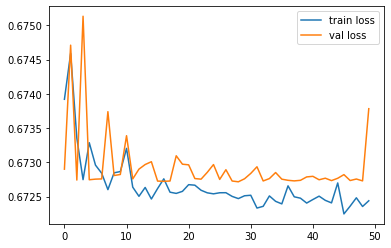

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

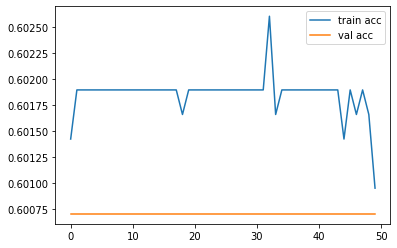

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(hist.history['precision_7'], label='train acc')
plt.plot(hist.history['val_precision_7'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
# Calculate the accuracy
test_preds = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
test_acc = np.sum(test_preds == y_true)/y_true.shape[0]

# Recall for each class
recall_vals = []
for i in range(3):
    class_idx = np.argwhere(y_true==i)
    total = len(class_idx)
    correct = np.sum(test_preds[class_idx]==i)
    recall = correct / total
    recall_vals.append(recall)

classes = [0,1]
# Calculate the test set accuracy and recall for each class
print('Test set accuracy is {:.3f}'.format(test_acc))
for i in range(2):
    print('For class {}, recall is {:.3f}'.format(classes[i],recall_vals[i]))

print("Weighted F score is {:.3f}".format(test_acc))
# print("Weighted F score is {:.3f}".format(calculate_weighted_f_score(y_true, y_pred)))

Test set accuracy is 0.608
For class 0, recall is 1.000
For class 1, recall is 0.000
Weighted F score is 0.608


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


# Completely New Model Build

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

In [ ]:
model = Sequential()
model.add(Conv2D(32, (1, 3), activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
model.add(MaxPooling2D((1, 4), strides=4))
model.add(Dropout(0.7))
model.add(Conv2D(64, (1, 3), activation='relu', padding='same',))
model.add(MaxPooling2D((1, 3), strides=3))
model.add(Dropout(0.7))
model.add(Conv2D(128, (1, 3), activation='relu', padding='same',))
model.add(MaxPooling2D((1, 2), strides=2))
model.add(Dropout(0.7))

model.add(Flatten())
model.add(Dense(1000,activation="relu"))
model.add(Dense(500,activation="relu"))
model.add(Dense(3,activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 5, 24, 32)         128       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 2, 6, 32)         0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 2, 6, 32)          0         
                                                                 
 conv2d_23 (Conv2D)          (None, 2, 6, 64)          6208      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 1, 2, 64)         0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 1, 2, 64)         

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy']) 

In [ ]:
batch_size = 12
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=50, validation_data=(X_val, y_val))

##### LABLES NEED TO BY 1x3 ARRAY

Epoch 1/50
352/352 [==============================] - 10s 5ms/step - loss: 1.1026 - accuracy: 0.3635 - val_loss: 1.0981 - val_accuracy: 0.3671
Epoch 2/50
352/352 [==============================] - 2s 5ms/step - loss: 1.0940 - accuracy: 0.3780 - val_loss: 1.0986 - val_accuracy: 0.3671
Epoch 3/50
352/352 [==============================] - 2s 5ms/step - loss: 1.0958 - accuracy: 0.3765 - val_loss: 1.0988 - val_accuracy: 0.3671
Epoch 4/50
352/352 [==============================] - 2s 5ms/step - loss: 1.0938 - accuracy: 0.3770 - val_loss: 1.0990 - val_accuracy: 0.3671
